In [ ]:
#|default_exp accel

# Denoising Diffusion Probabilistic Models with tinyai
with mixed precision.

Now that we written our base DDPM in last notebook, we can start `improving` it, We'll be using the same `tinyai` library we used in last notebook. \


## Imports

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

# @inplace
# def transformi(b): b[xl] = [TF.resize(TF.to_tensor(o), (32,32), antialias=True) for o in b[xl]]

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dt = dls.train
xb,yb = next(iter(dt))

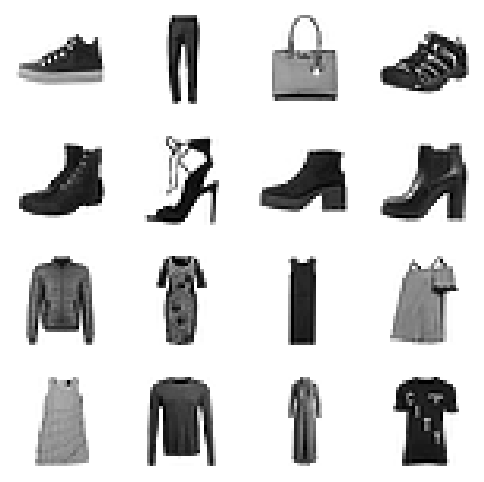

In [ ]:
show_images(xb[:16], imsize=1.5)

In [ ]:
betamin, betamax, T_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, T_steps)
alpha = 1.- beta  # α = 1-β
alphabar = alpha.cumprod(dim=0)  # ᾱ = Π α
sigma = beta.sqrt()  # σ = √β

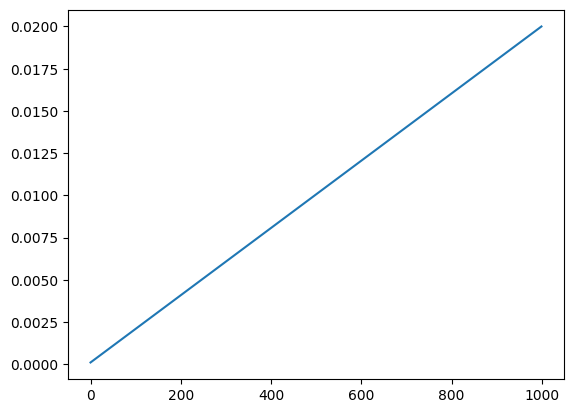

In [ ]:
plt.plot(beta);

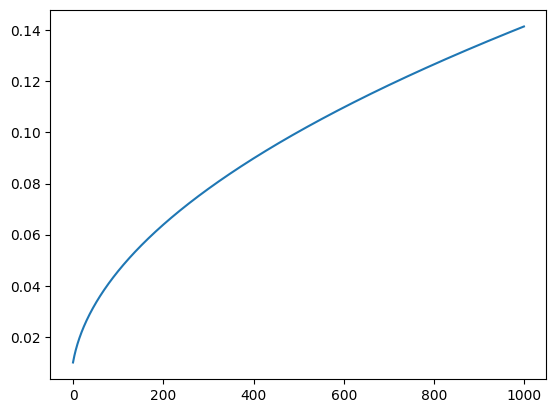

In [ ]:
plt.plot(sigma);

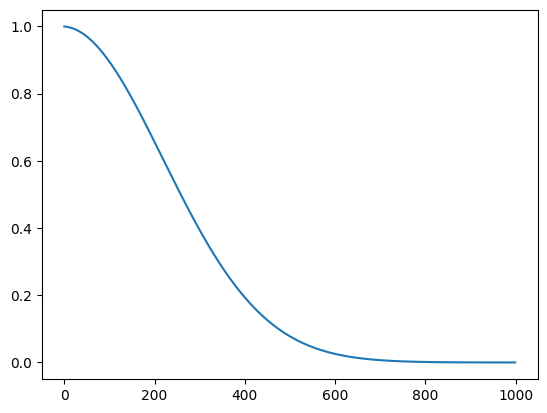

In [ ]:
plt.plot(alphabar);

In [ ]:
def noisify(x0, alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, T_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)  # ε ~ N(0,1) just noise
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alphabar_t.sqrt()*x0 + (1-alphabar_t).sqrt()*ε  # x_t = √ᾱ_t x_0 + √(1-ᾱ_t) * ε || Just noisy image
    return (xt, t.to(device)), ε

In [ ]:
(xt,t),ε = noisify(xb[:25],alphabar)  # 25 batch size
t  # t is the noise level

tensor([480, 151, 298, 714, 472, 114, 107, 936, 340, 447,  31,  51, 837, 940,
        532, 688, 672,  31, 789, 932, 209, 424, 958, 324, 193])

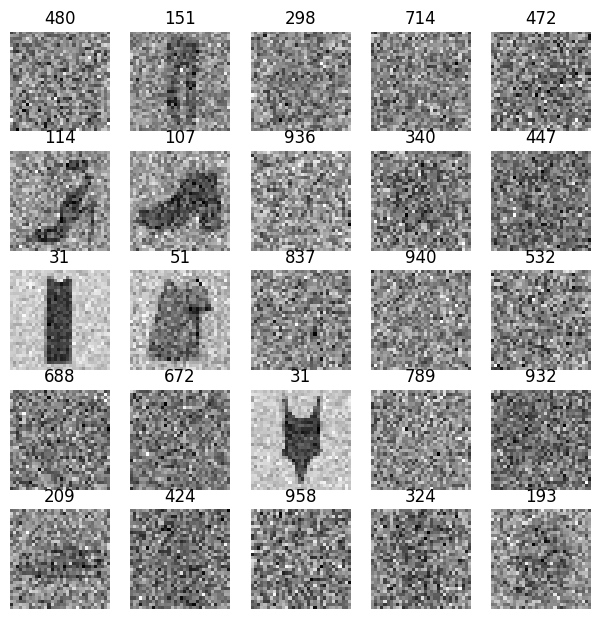

In [ ]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## Training

In [ ]:
from diffusers import UNet2DModel

In [ ]:
# Sampling is our inference for the model.
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, T_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(T_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        alphabar_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        betabar_t = 1 - alphabar[t]
        betabar_t1 = 1 - alphabar_t1
        x_0_hat = ((x_t - betabar_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * alphabar_t1.sqrt()*(1-alpha[t])/betabar_t + x_t * alpha[t].sqrt()*betabar_t1/betabar_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [ ]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, T_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.T_steps)  # This our liner noise schedule
        self.alpha = 1. - self.beta
        self.alphabar = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta.sqrt()

    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.alphabar)
    def sample(self, model, sz): return sample(model, sz, self.alpha, self.alphabar, self.sigma, self.T_steps)

Here we dont modify the TrainCB and we just use modify UNet2DModel

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
ddpm_cb = DDPMCB(T_steps=1000, beta_min=0.0001, beta_max=0.02)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


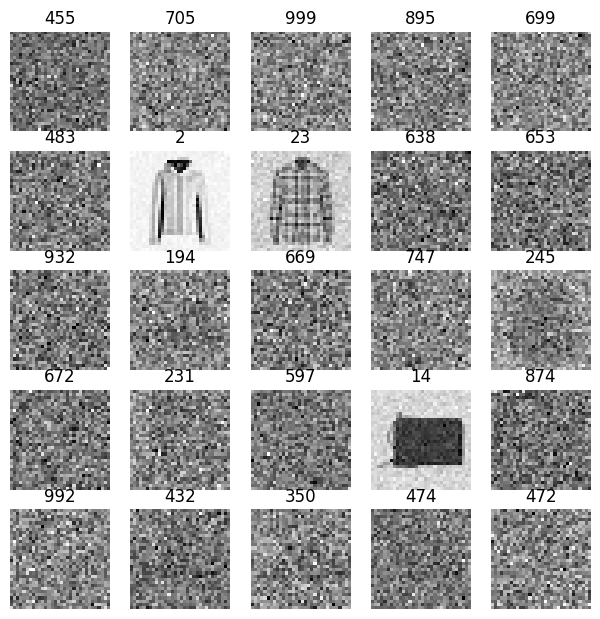

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [ ]:
lr = 5e-3
epochs = 4

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

We zero every second convolutional layer in up and down blocks, and we are using orthogonal initialization for downsamplers. \
As well as zeroing our weight on the output layer.

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
init_ddpm(model)

In [ ]:
opt_func = partial(optim.Adam, eps=1e-5)  # we increased our epsilon to 1e-5 from 1e-8 since it was crashing our training.

In [ ]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.143,0,train
0.026,0,eval
0.023,1,train
0.021,1,eval
0.020,2,train
0.018,2,eval
0.019,3,train
0.019,3,eval


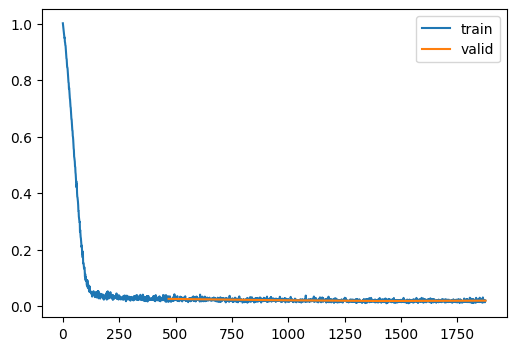

In [ ]:
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')

In [ ]:
torch.save(learn.model, mdl_path/'fashion_ddpm2.pkl')

In [ ]:
learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')

## Sampling

In [ ]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

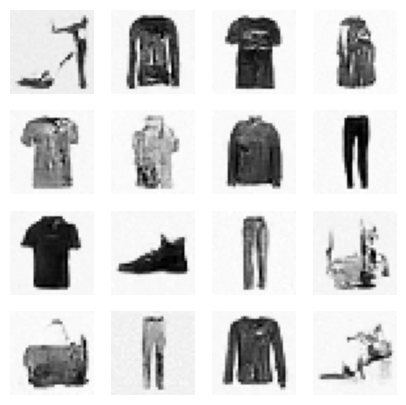

In [ ]:
show_images(samples[-1], figsize=(5,5))

## Mixed Precision
aka making it faster.

In [ ]:
bs = 512

In [ ]:
next(iter(DataLoader(tds['train'], batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

We are now adding noise in collate function (collate function is called when a batch in created from dataset).

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)

def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#|export
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10

    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)

    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

Since we are now using mixed precision, we went down from float32 -> float16, which means we train twice as fast, thats why we can incrase our epochs by 2x.

In [ ]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.267,0,train
0.033,0,eval
0.029,1,train
0.031,1,eval
0.024,2,train
0.023,2,eval
0.022,3,train
0.022,3,eval
0.020,4,train
0.019,4,eval


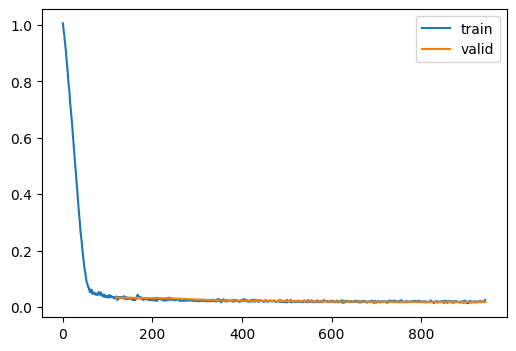

In [ ]:
learn.fit(epochs)

In [ ]:
samples = sample(learn.model, (32, 1, 32, 32), alpha, alphabar, sigma, T_steps)

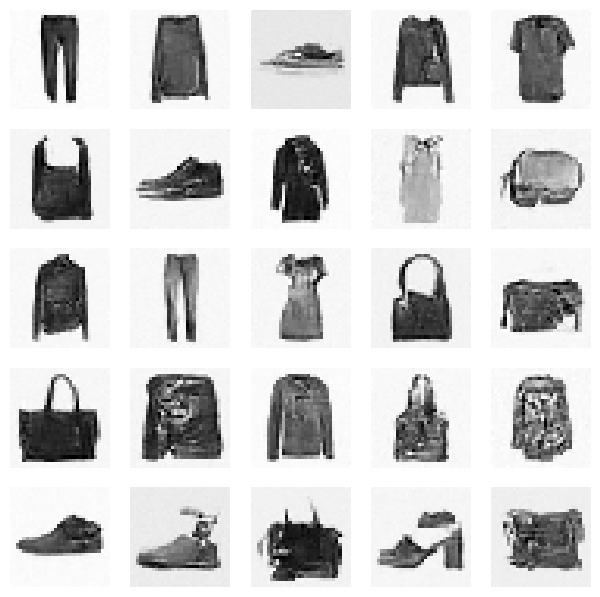

In [ ]:
show_images(samples[-1][:25], imsize=1.5)

In [ ]:
torch.save(learn.model, 'models/fashion_ddpm_mp.pkl')

## Accelerate

`pip install accelerate` before running this section.

In [ ]:
#|export
from accelerate import Accelerator

In [ ]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)

    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)

    def backward(self, learn): self.acc.backward(learn.loss)

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, T_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.267,0,train
0.033,0,eval
0.029,1,train
0.028,1,eval
0.024,2,train
0.023,2,eval
0.021,3,train
0.020,3,eval
0.020,4,train
0.019,4,eval


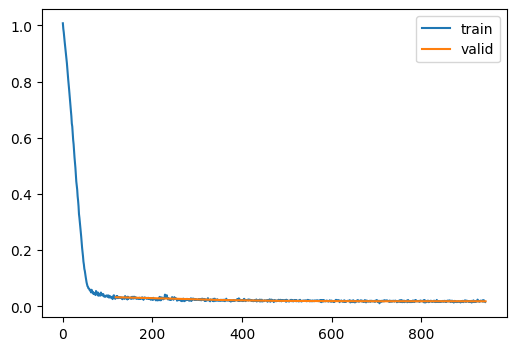

In [ ]:
learn.fit(epochs)

## A sneaky trick

a faster way to load data on One CPU

In [ ]:
class MultDL:
    def __init__(self, dl, mult=2): self.dl,self.mult = dl,mult
    def __len__(self): return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult): yield o

In [ ]:
dls.train = MultDL(dls.train)

In [ ]:
next(iter(dls.train))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(tensor([[[[-0.6111, -1.1989, -1.6629,  ..., -0.7548,  0.8478, -0.7463],
           [-2.3064,  1.0700,  2.0388,  ..., -0.7678, -0.7139, -1.9708],
           [-1.0453,  1.6779, -2.8541,  ..., -0.9632,  0.0336, -0.8867],
           ...,
           [ 0.1292, -1.2534,  1.1504,  ..., -0.2326, -0.8048, -0.3572],
           [ 0.0449,  1.1716,  0.6998,  ..., -1.1043, -0.0625, -0.4576],
           [-0.9921, -0.2013,  0.2527,  ...,  0.2510,  0.9980, -0.1063]]],
 
 
         [[[-2.0536, -0.1052,  1.7473,  ...,  0.7354,  1.0884, -0.1955],
           [-0.4815, -1.5793,  0.6943,  ..., -0.1199, -1.5775,  0.6925],
           [-0.2077,  0.0634, -0.8515,  ...,  0.9506, -0.5128, -0.1747],
           ...,
           [ 0.8544,  0.7266, -0.3990,  ..., -0.0806,  0.1674, -1.5582],
           [-0.8442,  0.0592, -0.9298,  ..., -0.1228,  0.5011, -0.2247],
           [-1.5940,  0.0730,  0.2244,  ...,  0.1420, -0.0744, -0.5297]]],
 
 
         [[[-0.9726,  0.0831,  1.2445,  ...,  0.1079, -0.3223,  0.8689],
       

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()